# Generative Adversarial Networks (GANs)

Generative Adversarial Networks belong to the set of algorithms named generative models. 

These algorithms belong to the field of unsupervised learning, a sub-set of ML which aims to study algorithms that learn the underlying structure of the given data, without specifying a target value. 

Generative models learn the intrinsic distribution function of the input data ${{p(x)}}$ or ${{p(x,y)}}$ if there are multiple targets/classes in the dataset), allowing them to generate both synthetic inputs x’ and outputs/targets y’, typically given some hidden parameters.

<br/>Some of the most relevant GAN pros and cons for the are:

* They currently generate the sharpest images
* They are easy to train (since no statistical inference is required), and only back-propogation is needed to obtain gradients
* GANs are difficult to optimize due to unstable training dynamics.
* No statistical inference can be done with them. GANs belong to the class of direct implicit density models; they model p(x) without explicitly defining the p.d.f.

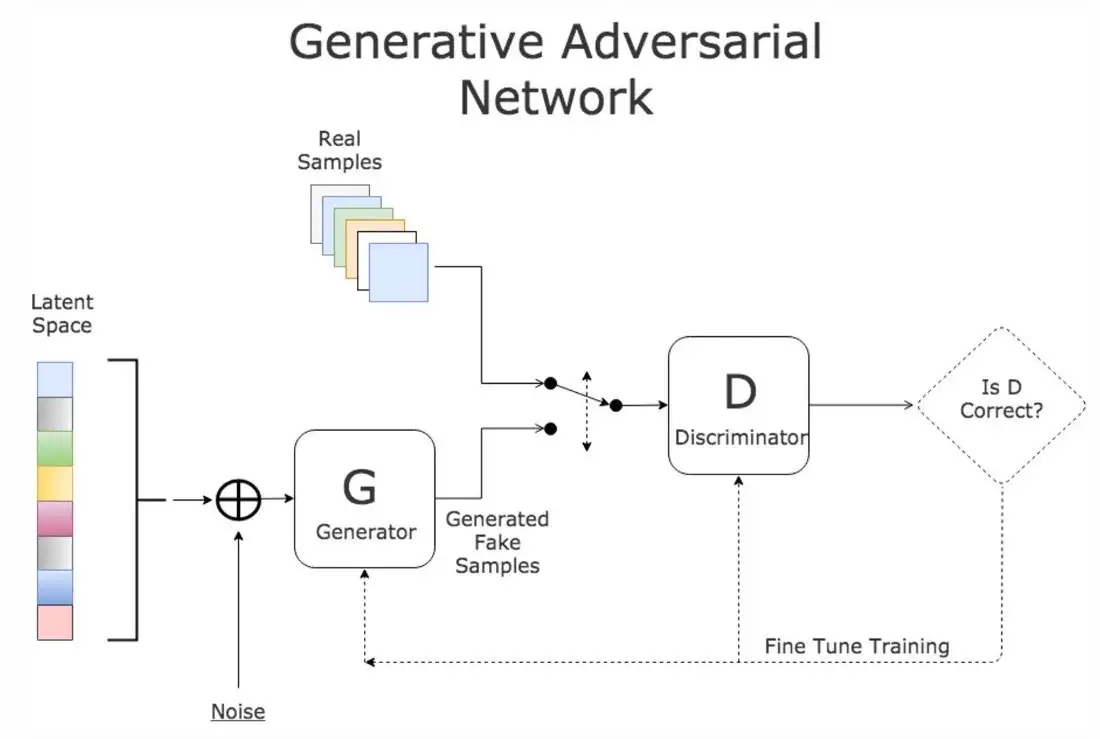

Generative Adversarial Networks are composed of two models:

* The first model is called a Generator and it aims to generate new data similar to the expected one. The Generator could be asimilated to a human art forger, which creates fake works of art.
* The second model is named the Discriminator. This model’s goal is to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger. In this scenario, a Discriminator is analogous to an art expert, which tries to detect artworks as truthful or fraud.

<br/>

### How do these models interact? 

Paraphrasing the [original paper](https://arxiv.org/abs/1406.2661) which proposed this framework, it can be thought of the Generator as having an adversary, the Discriminator. The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

## Mathematically Modeling a GAN

Though the GANs framework could be applied to any two models that perform the tasks described above, it is easier to understand when using universal approximators such as artificial neural networks.<br/><br/>

<p>A neural network G(z, θ₁) is used to model the Generator mentioned above. It’s role is mapping input noise variables z to the desired data space x (say images). Conversely, a second neural network D(x, θ₂) models the discriminator and outputs the probability that the data came from the real dataset, in the range (0,1). In both cases, θᵢ represents the weights or parameters that define each neural network.</p><br/>

<p>As a result, the Discriminator is trained to correctly classify the input data as either real or fake. This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).</p><br/>

<p>Furthermore, the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes D(G(z)).</p><br/>

<p>In practice, the logarithm of the probability (e.g. log D(…)) is used in the loss functions instead of the raw probabilies, since using a log loss heavily penalises classifiers that are confident about an incorrect classification.</p>



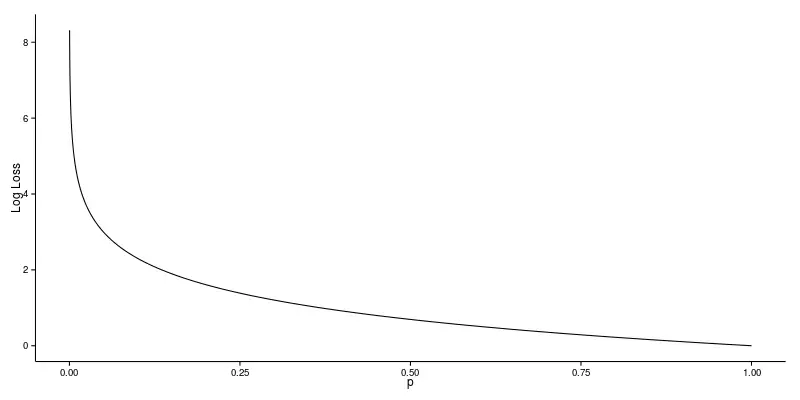

After several steps of training, if the Generator and Discriminator have enough capacity (if the networks can approximate the objective functions), they will reach a point at which both cannot improve anymore. At this point, the generator generates realistic synthetic data, and the discriminator is unable to differentiate between the two types of input.

Since during training both the Discriminator and Generator are trying to optimize opposite loss functions, they can be thought of two agents playing a minimax game with value function V(G,D). In this minimax game, the generator is trying to maximize it’s probability of having it’s outputs recognized as real, while the discriminator is trying to minimize this same value.

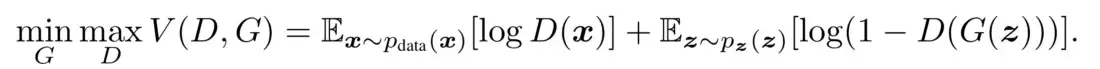

### The fundamental steps to train a GAN can be described as following:

1. Sample a noise set and a real-data set, each with size m.
2. Train the Discriminator on this data.
3. Sample a different noise subset with size m.
4. Train the Generator on this data.
5. Repeat from Step 1.

---


# Example - AI Generated Fashsion using MNIST Dataset

## 1. Import Dependencies and Data

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [ ]:
# Bringing in tensorflow GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

In [ ]:
for pgu in gpus:
  print(gpu)

In [ ]:
# Brining in tensorflow datasets for fashion MNIST 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

Next we need to bring in Fashion MNIST dataset from tensorflow dataset libraries. You can learn more about this data set from [here](https://www.tensorflow.org/datasets/catalog/fashion_mnist) 

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
ds.as_numpy_iterator().next().keys()


In [ ]:
ds.as_numpy_iterator().next()['label']

## 2. Visualize Data and Build Dataset:

In [ ]:
# Do some data transformation
import numpy as np

In [ ]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()['image']

In [ ]:
import numpy as np

sample = dataiterator.next()
print(sample['image'].shape)

In [ ]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [ ]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

Steps to bring data from TensorFlow Data Pipeline:
* Map: Any transformation that needs to be done as preprocessing step
* Cache: Saving the batch of data in memory
* Shuffle: Shuffling the data (By passing shuffling buffer)
* Batch: Group the dataset into batches of certain size
* Prefetch:Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s , the input pipeline is reading the data for step s+1

In [ ]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

## 3. Build Neural Network
###3.1 Import Modelling Components

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

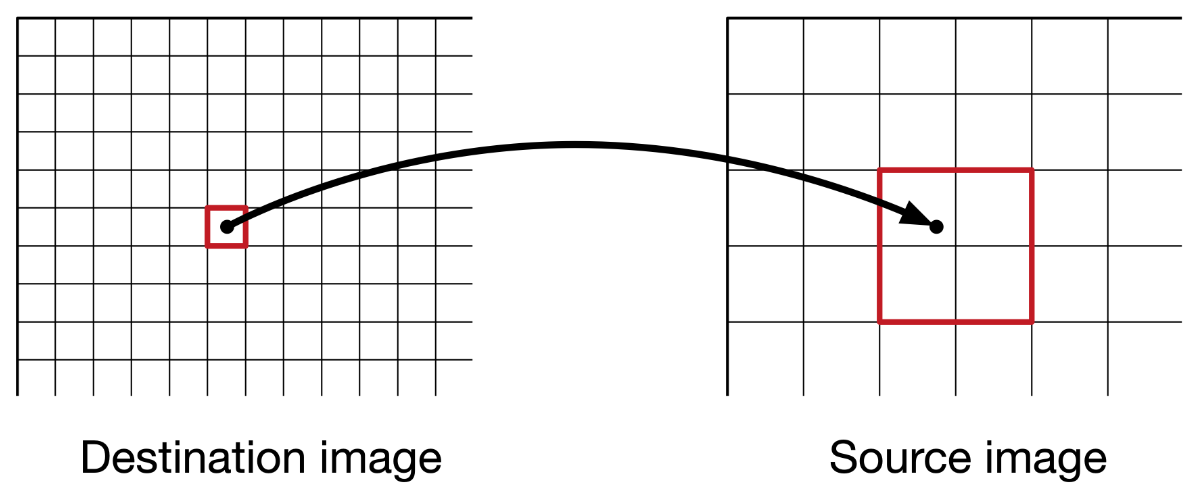

In [ ]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

So the objective of the next step is to feed 128 random arrays of size 4 and pass it to our network and our generator should be able to generate images from those. These random inputs are also refered to as latent space. n  

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

<font color="red"> <h1> Classroom Discussion: </h1></font>
<p> What do you think is the best indicator for the performance of a Generator ? </p> This will come handy as we combine the two models. 

### 3.3 Build Discriminator

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Let's test the discriminator with one of our original images:

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
print(img.shape)
print(f"Image dimension: {img.shape}")
print(f"Prediction: {discriminator.predict(img)}")

## 4. Construct Training Loop
### 4.1 Setup Losses and Optimizer

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        # for i in range(self.num_img):
        #     img = array_to_img(generated_images[i])
        #     img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## 5. Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=1, callbacks=[ModelMonitor()])

## 6. Review Performance 

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## 7. Test out our GNs

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        img = np.squeeze(imgs[(r+1)*(c+1)-1])
        ax[r][c].imshow(img)